# Introduction

**Problem statement:**

Building a model to predict how capable a loan applicant is of repaying loan, to sanction loan only for the applicants who are likely to repay the loan.

**Objectives and Constraints:**

1. There are no latency constraints until we deliver our prediction by the same day.
2. Our predictions should be in the format of probabilities that the borrower is going to repay the loan.
3. If predictions are flawed and a bankrupt borrower is given a high probability of return, lenders could lose a lot of money.

**Dataset:**

The main dataset for train and test is from the current applications for different types of debts. There are also data tables from the Credit Bureau (may be a central repository to all banks about borrower credibility) and data tables from previous applications related to current applications. 

Summary of datasets -

[1]

*application_{train|test}.csv* - current applications of "Home credit" financing company.

Type of features - customer details like salary, age , employment details, customer previous credit score (if any) , customer housing and surroundings information , credit details and application details (form filled for application).

No. of features - 121

[2]

*bureau.csv* - each current application has a ‘SK_ID_CURR’ bureau.csv has previous credits information for each ‘SK_ID_CURR’ thus there are multiple ‘SK_ID_BUREAU’. Each previous credit has a row describing the previous credits end date , start date , amount , etc.

No. of features - 17

[3]

*bureau_balance.csv* - for each month in the past during when "SK_ID_BUREAU" was instrumental, it gives a status of credit (if active , completed , bad debt , etc)

No. of features - 3

[4]

*previous_application.csv* - like the bureau table it has ‘SK_ID_PREV’ , bureau table has data from previous credits outside “Home Credit” company, whereas previous_application.csv has data from previous customers of “Home Credit”. It covers more extensive information in data similar to application_{train|test}.csv.

No. of features - 37

[5]

*credit_card_balance , installments_payments.csv , POS_CASH_balance.csv* - these are time series data related to "SK_ID_PREV", POS stands for 'point of sale' - that is credit related to POS of goods.

No. of features - 23 , 8 , 8

**Performance Metrics**

ROC AUC should be chosen as metric as it concentrates on TPR and FPR of positive class (positive class in this case is credit default / 'TARGET' = 1). TPR is the ratio of correctly predicting default upon total defaults and FPR is the ratio of other classes we predict as default upon total non defaults, if FPR is high then we are going to lose business.


# Imports

In [ ]:

# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())


In [ ]:

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from cuml import TSNE
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:

description = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/HomeCredit_columns_description.csv' , encoding = "ISO-8859-1" )

train_main = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/application_train.csv')
test_main = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/application_test.csv')

bureau = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/bureau.csv')
bureau_balances = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/bureau_balance.csv')

prev_applicants = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/previous_application.csv')
POS_balances = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/POS_CASH_balance.csv')
card_balances = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/credit_card_balance.csv')
installments = pd.read_csv('/content/gdrive/My Drive/AAI/Kaggle/installments_payments.csv')


# Preprocessing

In [ ]:

def describe_missing( df , color , fig_size):
      
    bool_missing = np.any(df.isna() , axis = 0)
    bool_missing = set(bool_missing.index[bool_missing])

    print('No. of missing columns - ',len(bool_missing),'\n')
    print(bool_missing,'\n')

    x_axis = []
    y_axis = []
    for i in list(bool_missing):
        x_axis.append(i)
        y_axis.append(np.mean(df[i].isna()))
                          
    plt.figure(figsize=fig_size , facecolor="#e1ddbf")
    plt.xlabel('Columns')
    plt.ylabel('% of missing values')
    plt.bar(x_axis , y_axis , color = color , zorder=2.5)
    plt.xticks(rotation='vertical')
    plt.grid(axis='y')
    plt.show()

def categorical_to_numerical( df , columns ):

    for i in columns:
        te_dict = {m:l+1 for l,m in enumerate(df[i].unique())}
        te_dict['XNA'] = 0
        te_dict['XAP'] = 0 
        te_dict['Unknown'] = 0
        te_dict['not specified'] = 0
        te_dict[np.nan] = 0
        df[i] = df[i].apply(lambda x:te_dict.get(x , 0))

def rnn_preprocess( data , groupby_column , time_column , max_len ):

    data.sort_values(by=time_column , ascending=False , inplace=True)
    data = data.groupby(groupby_column , as_index=False).apply( 
        lambda x : x.iloc[:max_len , :]
        if (len(x) >= max_len)      
        else
        x.append( pd.DataFrame({ time_column : x[time_column].iloc[0].repeat(max_len-len(x)) , 
                                 groupby_column : x[groupby_column].iloc[0] }) )
        ).reset_index(drop = True)   

    return data


## train_main & test_main  

### Missing values 

No. of missing columns -  67 

{'AMT_ANNUITY', 'COMMONAREA_AVG', 'LANDAREA_MEDI', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE', 'AMT_GOODS_PRICE', 'ENTRANCES_MEDI', 'ELEVATORS_MEDI', 'YEARS_BUILD_MEDI', 'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'NONLIVINGAREA_AVG', 'LIVINGAREA_MODE', 'DAYS_LAST_PHONE_CHANGE', 'LIVINGAREA_MEDI', 'APARTMENTS_AVG', 'FLOORSMAX_MEDI', 'FLOORSMIN_MODE', 'BASEMENTAREA_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLOORSMIN_MEDI', 'NAME_TYPE_SUITE', 'APARTMENTS_MODE', 'FLOORSMIN_AVG', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_MON', 'YEARS_BEGINEXPLUATATION_MEDI', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'COMMONAREA_MODE', 'YEARS_BUILD_MODE', 'AMT_REQ_CREDIT_BUREAU_DAY', 'BASEMENTAREA_MODE', 'COMMONAREA_MEDI', 'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'FLOORSMAX_AVG', 'LANDAREA_MODE', 'EXT_SOURCE_1', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'YEARS_BEG

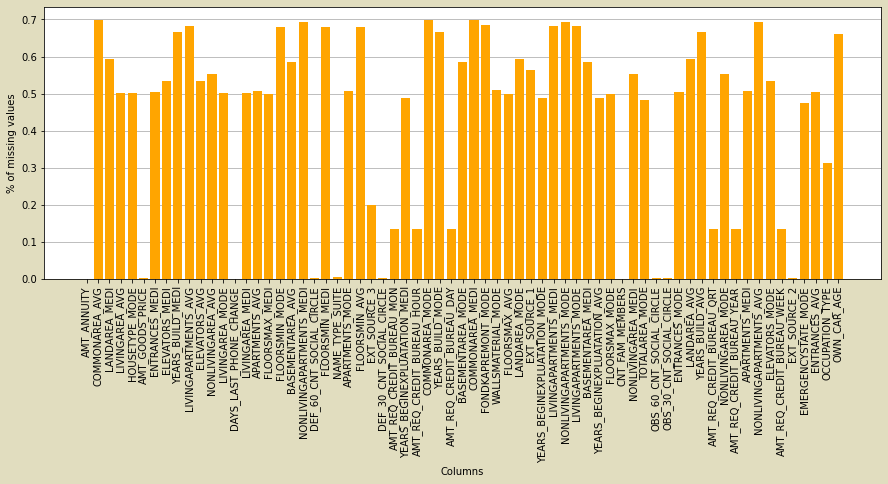

In [ ]:

describe_missing( train_main , 'orange' , (15,5) )


No. of missing columns -  64 

{'AMT_ANNUITY', 'COMMONAREA_AVG', 'LANDAREA_MEDI', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE', 'ENTRANCES_MEDI', 'ELEVATORS_MEDI', 'YEARS_BUILD_MEDI', 'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'NONLIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'APARTMENTS_AVG', 'FLOORSMAX_MEDI', 'FLOORSMIN_MODE', 'BASEMENTAREA_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLOORSMIN_MEDI', 'NAME_TYPE_SUITE', 'APARTMENTS_MODE', 'FLOORSMIN_AVG', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_MON', 'YEARS_BEGINEXPLUATATION_MEDI', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'COMMONAREA_MODE', 'YEARS_BUILD_MODE', 'AMT_REQ_CREDIT_BUREAU_DAY', 'BASEMENTAREA_MODE', 'COMMONAREA_MEDI', 'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'FLOORSMAX_AVG', 'LANDAREA_MODE', 'EXT_SOURCE_1', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_MODE', 'NONLI

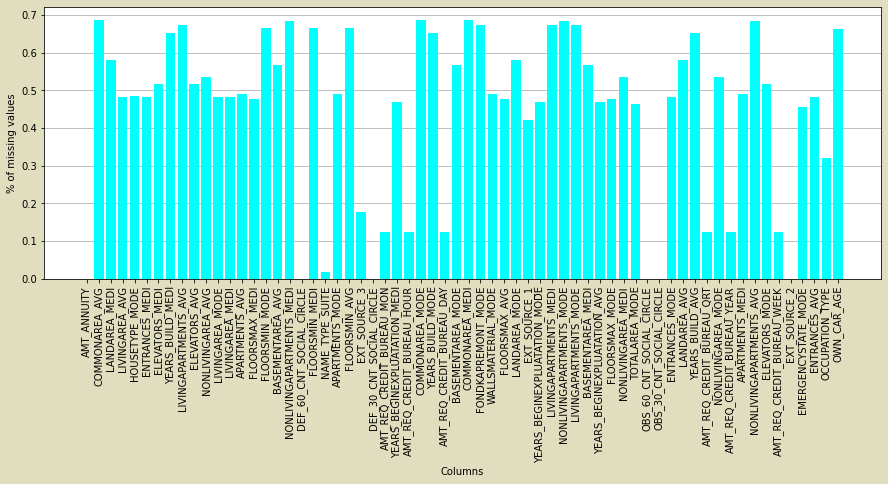

In [ ]:

describe_missing( test_main , 'cyan' , (15,5) )


In [ ]:

# Filling NaN values is not required when using LightBGM, but filling NaN values can give additional meaning in case we are not filling 0s
# However, we will be filling only columns with 30 percent missing values , if we fill most of the column with mean values the column becomes redundant. 

bool_missing_train = np.any(train_main.isna() , axis = 0)

te1 = []
te2 = []
for i in bool_missing_train.index[bool_missing_train]:
    te1.append(i)
    te2.append(np.mean(train_main[i].isna()))

print(np.array(te1)[np.array(te2) < 0.3])
del(te1,te2)


['AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'CNT_FAM_MEMBERS'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'OBS_30_CNT_SOCIAL_CIRCLE'
 'DEF_30_CNT_SOCIAL_CIRCLE' 'OBS_60_CNT_SOCIAL_CIRCLE'
 'DEF_60_CNT_SOCIAL_CIRCLE' 'DAYS_LAST_PHONE_CHANGE'
 'AMT_REQ_CREDIT_BUREAU_HOUR' 'AMT_REQ_CREDIT_BUREAU_DAY'
 'AMT_REQ_CREDIT_BUREAU_WEEK' 'AMT_REQ_CREDIT_BUREAU_MON'
 'AMT_REQ_CREDIT_BUREAU_QRT' 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [ ]:

# filling NaN values with column average
to_be_averaged = [
    'AMT_REQ_CREDIT_BUREAU_YEAR' , 'AMT_REQ_CREDIT_BUREAU_WEEK' , 'AMT_REQ_CREDIT_BUREAU_QRT' , 'AMT_REQ_CREDIT_BUREAU_DAY' , 
    'AMT_REQ_CREDIT_BUREAU_HOUR' , 'AMT_REQ_CREDIT_BUREAU_MON' , 'DAYS_LAST_PHONE_CHANGE' , 'OBS_30_CNT_SOCIAL_CIRCLE' , 
    'DEF_30_CNT_SOCIAL_CIRCLE' , 'OBS_60_CNT_SOCIAL_CIRCLE' , 'DEF_60_CNT_SOCIAL_CIRCLE' ,
]

for i in to_be_averaged:
    train_main[i].fillna(np.mean(train_main[i]) , inplace=True)
    test_main[i].fillna(np.mean(test_main[i]) , inplace=True)

#  filling NaN values with average ratio of 2 columns
members_to_population_ratio_tr =  np.mean(train_main['CNT_FAM_MEMBERS'] / train_main['REGION_POPULATION_RELATIVE'])
members_to_population_ratio_t =  np.mean(test_main['CNT_FAM_MEMBERS'] / test_main['REGION_POPULATION_RELATIVE'])

train_main['CNT_FAM_MEMBERS'].fillna(lambda x : members_to_population_ratio_tr * train_main['REGION_POPULATION_RELATIVE'] , inplace=True)
test_main['CNT_FAM_MEMBERS'].fillna(lambda x : members_to_population_ratio_te * test_main['REGION_POPULATION_RELATIVE'] , inplace=True)


### Feature engineering

In [ ]:

# New features for train_main & test_main
train_main['CHILD_VS_INCOME'] = train_main['CNT_CHILDREN'] / train_main['AMT_INCOME_TOTAL'] 
train_main['INCOME_CREDIT_SHARE'] = train_main['AMT_CREDIT'] / train_main['AMT_INCOME_TOTAL']
train_main['INCOME_ANNUITY_SHARE'] = train_main['AMT_ANNUITY'] / train_main['AMT_INCOME_TOTAL']
train_main['INTEREST_RATE'] = train_main['AMT_ANNUITY'] / train_main['AMT_CREDIT']
train_main['PURCHASE_POWER'] = train_main['AMT_GOODS_PRICE'] / (train_main['AMT_INCOME_TOTAL'] * train_main['DAYS_EMPLOYED'])
train_main['CAR_PURCHASE_POWER'] = train_main['DAYS_EMPLOYED'] / train_main['OWN_CAR_AGE']
train_main.replace([np.inf,-np.inf], np.nan , inplace=True)
train_main['MACRO_OBS_30'] = train_main['OBS_30_CNT_SOCIAL_CIRCLE'] / train_main['REGION_POPULATION_RELATIVE']
train_main['MACRO_OBS_60'] = train_main['OBS_60_CNT_SOCIAL_CIRCLE'] / train_main['REGION_POPULATION_RELATIVE']
train_main['MACRO_DEF_30'] = train_main['DEF_30_CNT_SOCIAL_CIRCLE'] / train_main['REGION_POPULATION_RELATIVE']
train_main['MACRO_DEF_60'] = train_main['DEF_60_CNT_SOCIAL_CIRCLE'] / train_main['REGION_POPULATION_RELATIVE']
train_main['DAYS_EMPLOYED_TO_BIRTH'] = train_main['DAYS_EMPLOYED'] / train_main['DAYS_BIRTH']

test_main['CHILD_VS_INCOME'] = test_main['CNT_CHILDREN'] / test_main['AMT_INCOME_TOTAL'] 
test_main['INCOME_CREDIT_SHARE'] = test_main['AMT_CREDIT'] / test_main['AMT_INCOME_TOTAL']
test_main['INCOME_ANNUITY_SHARE'] = test_main['AMT_ANNUITY'] / test_main['AMT_INCOME_TOTAL']
test_main['INTEREST_RATE'] = test_main['AMT_ANNUITY'] / test_main['AMT_CREDIT']
test_main['PURCHASE_POWER'] = test_main['AMT_GOODS_PRICE'] / (test_main['AMT_INCOME_TOTAL'] * test_main['DAYS_EMPLOYED'])
test_main['CAR_PURCHASE_POWER'] = test_main['DAYS_EMPLOYED'] / test_main['OWN_CAR_AGE']
test_main.replace([np.inf,-np.inf], np.nan , inplace=True)
test_main['MACRO_OBS_30'] = test_main['OBS_30_CNT_SOCIAL_CIRCLE'] / test_main['REGION_POPULATION_RELATIVE']
test_main['MACRO_OBS_60'] = test_main['OBS_60_CNT_SOCIAL_CIRCLE'] / test_main['REGION_POPULATION_RELATIVE']
test_main['MACRO_DEF_30'] = test_main['DEF_30_CNT_SOCIAL_CIRCLE'] / test_main['REGION_POPULATION_RELATIVE']
test_main['MACRO_DEF_60'] = test_main['DEF_60_CNT_SOCIAL_CIRCLE'] / test_main['REGION_POPULATION_RELATIVE']
test_main['DAYS_EMPLOYED_TO_BIRTH'] = test_main['DAYS_EMPLOYED'] / test_main['DAYS_BIRTH']

# replace categorical features to numerical
categorical_columns = list(set(train_main.columns) - set(train_main._get_numeric_data().columns))
categorical_to_numerical( train_main , categorical_columns )
categorical_to_numerical( test_main , categorical_columns )

# converting to float 32 and rounding to 3 decimal places to support rapid's cuml GPU settings
train_main = train_main.astype(np.float32)
test_main = test_main.astype(np.float32)


## bureau & bureau balance

### Missing values 

No. of missing columns -  7 

{'DAYS_ENDDATE_FACT', 'AMT_ANNUITY', 'AMT_CREDIT_SUM_LIMIT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM', 'AMT_CREDIT_MAX_OVERDUE'} 



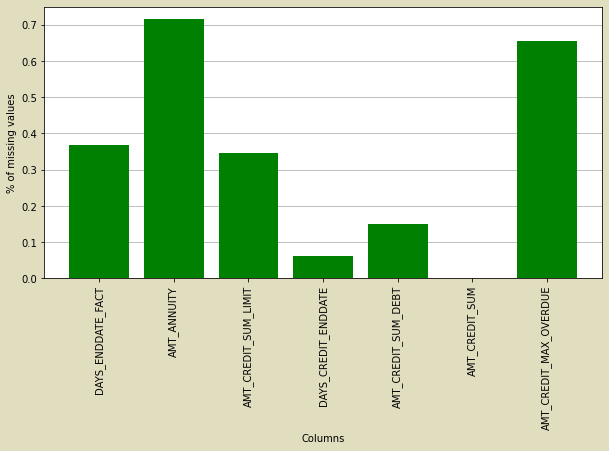

In [ ]:

describe_missing( bureau , 'green' , (10,5) )


In [ ]:

# Note: bureau balances table has no null values

# To check 'AMT_CREDIT_SUM' less than 100
print('\n' , np.mean(bureau['AMT_CREDIT_SUM']<100) , '\n' , sep = '')

# To check if NaN values in 'DAYS_ENDDATE_FACT' and 'DAYS_CREDIT_ENDDATE' relatibility
print(np.mean((bureau['DAYS_ENDDATE_FACT'].isna()) & (bureau['DAYS_CREDIT_ENDDATE'].notna())))
print(np.mean((bureau['DAYS_ENDDATE_FACT'].isna()) & (bureau['DAYS_CREDIT_ENDDATE'].isna())) , '\n') 

# To check errors from formatting as credit + debit = limit
print(np.mean(bureau['AMT_CREDIT_SUM_DEBT'] + bureau['AMT_CREDIT_SUM_LIMIT']  == bureau['AMT_CREDIT_SUM']))
print(np.mean((bureau['AMT_CREDIT_SUM_DEBT']>0) & (bureau['AMT_CREDIT_SUM']>0) & (bureau['AMT_CREDIT_SUM_LIMIT']>0)) , '\n')

# To check debt & credit relationship
print(np.mean((bureau['AMT_CREDIT_SUM_DEBT'].isna()) & (bureau['AMT_CREDIT_SUM'].isna())))
print(np.mean((bureau['AMT_CREDIT_SUM_DEBT'].isna()) & (bureau['AMT_CREDIT_SUM'].notna()))) 
print(np.mean((bureau['AMT_CREDIT_SUM_DEBT'].notna()) & (bureau['AMT_CREDIT_SUM'].isna()))) ### will be dropped

print(np.mean(bureau['AMT_CREDIT_SUM_DEBT'] > bureau['AMT_CREDIT_SUM']))
print(np.mean(bureau['AMT_CREDIT_SUM_DEBT'] < bureau['AMT_CREDIT_SUM']))
print(np.mean(bureau['AMT_CREDIT_SUM_DEBT'] == bureau['AMT_CREDIT_SUM']) , '\n')



0.039212247761047946

0.32677688781585945
0.04239268993514438 

0.0620527048032309
0.025685901185485204 

0.0
0.15011931755948982
7.573868522303295e-06
0.017269585441393405
0.7918904841915886
0.04071303893900589 



In [ ]:

# Handling missing values
bureau = bureau.loc[bureau['AMT_CREDIT_SUM'] > 100,:]
bureau['AMT_ANNUITY'].fillna(0 , inplace=True) 
bureau['AMT_CREDIT_MAX_OVERDUE'].fillna(0 , inplace=True)
bureau['AMT_CREDIT_SUM_DEBT'].fillna(0 , inplace=True)
bureau['AMT_CREDIT_SUM_LIMIT'].fillna(0 , inplace=True)

bureau = bureau.loc[bureau['DAYS_ENDDATE_FACT'] > bureau['DAYS_CREDIT'] , :]
bureau = bureau.loc[bureau['DAYS_CREDIT_ENDDATE'] > bureau['DAYS_CREDIT'] , :]

avg_factdays_per_unit_credit = np.mean((bureau['DAYS_ENDDATE_FACT'] - bureau['DAYS_CREDIT']) / bureau['AMT_CREDIT_SUM'])
avg_days_per_unit_credit = np.mean((bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']) / bureau['AMT_CREDIT_SUM'])

bureau['DAYS_ENDDATE_FACT'].fillna(avg_factdays_per_unit_credit * bureau['AMT_CREDIT_SUM'] + bureau['DAYS_CREDIT'] , inplace=True)
bureau['DAYS_CREDIT_ENDDATE'].fillna(avg_days_per_unit_credit * bureau['AMT_CREDIT_SUM'] + bureau['DAYS_CREDIT']  , inplace=True)

bureau.reset_index(inplace = True , drop = True)


### Feature engineering


 Status of Credit Bureau loan during the month (active, closed, DPD0-30, [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60, 5 means DPD 120+ or sold or written off ] ) 



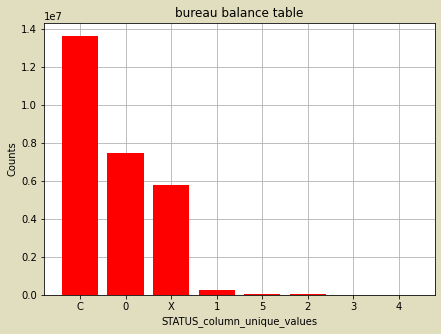

In [ ]:

# Description of STATUS column in bureau balances
print('\n' , description.loc[description['Row'] == 'STATUS' , 'Description'].reset_index().iloc[0,1] , '\n')

te = bureau_balances['STATUS'].value_counts()
plt.figure(figsize = (7,5) , facecolor="#e1ddbf")
plt.title('bureau balance table')
plt.xlabel('STATUS_column_unique_values')
plt.ylabel('Counts')
plt.bar( te.index , te , color = 'red' , zorder=2.5)
plt.grid()
plt.plot()
del(te)


In [ ]:

# Extracting count of different status for a bureau ID
bureau_balances = bureau_balances.pivot_table( index = 'SK_ID_BUREAU' , columns = 'STATUS' , 
                                               margins = False , fill_value = 0 , 
                                               aggfunc = 'count'  
                                             )['MONTHS_BALANCE'].reset_index()

bureau_balances


STATUS,SK_ID_BUREAU,0,1,2,3,4,5,C,X
0,5001709,0,0,0,0,0,0,86,11
1,5001710,5,0,0,0,0,0,48,30
2,5001711,3,0,0,0,0,0,0,1
3,5001712,10,0,0,0,0,0,9,0
4,5001713,0,0,0,0,0,0,0,22
...,...,...,...,...,...,...,...,...,...
817390,6842884,9,0,0,0,0,0,20,19
817391,6842885,12,0,0,0,0,12,0,0
817392,6842886,8,0,0,0,0,0,25,0
817393,6842887,6,0,0,0,0,0,31,0


In [ ]:

# Extracting cumulative principal balance per bureau ID (if principle repaid it would be deducted from cumulative principal)
bureau.drop('CREDIT_CURRENCY' , axis = 1 , inplace = True)

te1 = bureau[['SK_ID_CURR' , 'SK_ID_BUREAU']]
te1['CUM_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM']
te1['DAYS'] = bureau['DAYS_CREDIT']
te1['position'] = 's'

te2 = bureau[['SK_ID_CURR' , 'SK_ID_BUREAU']] 
te2['CUM_CREDIT_SUM'] = -bureau['AMT_CREDIT_SUM']
te2['DAYS'] = bureau['DAYS_CREDIT_ENDDATE']
te2['position'] = 'e'

te = pd.concat([te1,te2] , ignore_index=True)
te.sort_values('DAYS' , inplace=True , ignore_index=True)
te['CUM_CREDIT_SUM'] = te[['SK_ID_CURR','CUM_CREDIT_SUM']].groupby('SK_ID_CURR').cumsum()['CUM_CREDIT_SUM']
te = te.loc[ te['position'] == 's' , ['SK_ID_BUREAU' , 'CUM_CREDIT_SUM'] ]

bureau = bureau.merge(te, on = 'SK_ID_BUREAU')
del(te1,te2,te)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:

# Extra features
bureau['DAYS_DELTA'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
bureau['AMT_CREDIT_TERM_RATIO'] = bureau['AMT_CREDIT_SUM'] / (bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT'])
bureau['DEBT_TO_CREDIT'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM'] 

# Convert categorical features to numeric with risk strategy
print(bureau['CREDIT_ACTIVE'].unique() , '\n')
print(bureau['CREDIT_TYPE'].unique())
credit_active_tokens = {'Closed':1 , 'Active':2 , 'Sold':3 , 'Bad debt':4}
credit_type_tokens = {'Unknown type of loan':0 , 'Another type of loan':0 ,
                      'Consumer credit':1 ,  'Mobile operator loan':1 , 'Credit card':2 ,
                      'Cash loan (non-earmarked)':2 , 'Car loan':3 , 'Microloan':3 , 'Real estate loan':4 , 'Mortgage':4 ,                     
                      'Loan for working capital replenishment':6 , 'Loan for business development':5 ,'Loan for the purchase of equipment':5 ,
                      'Loan for purchase of shares (margin lending)':6 , 'Interbank credit':6
                     }

bureau['CREDIT_ACTIVE'] = bureau['CREDIT_ACTIVE'].apply(lambda x: credit_active_tokens.get(x , 0))
bureau['CREDIT_TYPE'] = bureau['CREDIT_TYPE'].apply(lambda x: credit_type_tokens.get(x , 0))

# Merging bureau_balances table into bureau table
bureau = bureau.merge(bureau_balances, on = 'SK_ID_BUREAU' , how = 'left')

# Missing bureau id (from bureau table) in bureau balances table create na values 
bureau['0'].fillna(np.mean(bureau['0']) , inplace = True)
bureau['1'].fillna(np.mean(bureau['1']) , inplace = True)
bureau['2'].fillna(np.mean(bureau['2']) , inplace = True)
bureau['3'].fillna(np.mean(bureau['3']) , inplace = True)
bureau['4'].fillna(np.mean(bureau['4']) , inplace = True)
bureau['5'].fillna(np.mean(bureau['5']) , inplace = True)
bureau['C'].fillna(np.mean(bureau['C']) , inplace = True)
bureau['X'].fillna(np.mean(bureau['X']) , inplace = True)

# Combining average and max values of different bureau ids per 'SK_ID_CURR'
te = bureau.drop('SK_ID_BUREAU' , axis = 1)
final_bureau = te.groupby('SK_ID_CURR' , as_index=False).agg('mean')

# Rarely occuring patterns will be captured by groupby mean so in max we will be take rare patterns from frequent patters eg: 2 in 2,0,0,0,0,1,0...
te = te[['SK_ID_CURR','DAYS_CREDIT' , 'DAYS_CREDIT_ENDDATE' , 'AMT_CREDIT_SUM' , 'CUM_CREDIT_SUM' , 'AMT_CREDIT_TERM_RATIO' , '0' , '1' , '2']].groupby('SK_ID_CURR' , as_index=False).agg('max')
final_bureau = final_bureau.merge(te , on='SK_ID_CURR' , suffixes=('_avg','_max'))
final_bureau = final_bureau.merge(bureau[['SK_ID_CURR' , 'CUM_CREDIT_SUM']].groupby('SK_ID_CURR').std() , on='SK_ID_CURR')
final_bureau.reset_index(drop=True , inplace=True)
del(te)

bureau = bureau.astype(np.float32)
final_bureau = final_bureau.astype(np.float32)


['Closed' 'Sold' 'Active' 'Bad debt'] 

['Consumer credit' 'Credit card' 'Car loan' 'Mortgage' 'Microloan'
 'Loan for business development' 'Loan for working capital replenishment'
 'Unknown type of loan' 'Another type of loan' 'Cash loan (non-earmarked)'
 'Loan for the purchase of equipment' 'Real estate loan'
 'Interbank credit' 'Loan for purchase of shares (margin lending)']


## prev_applicants

### Missing values

No. of missing columns -  16 

{'DAYS_LAST_DUE_1ST_VERSION', 'AMT_ANNUITY', 'RATE_DOWN_PAYMENT', 'DAYS_LAST_DUE', 'DAYS_FIRST_DUE', 'NAME_TYPE_SUITE', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'RATE_INTEREST_PRIVILEGED', 'PRODUCT_COMBINATION', 'RATE_INTEREST_PRIMARY', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_TERMINATION', 'AMT_DOWN_PAYMENT', 'NFLAG_INSURED_ON_APPROVAL'} 



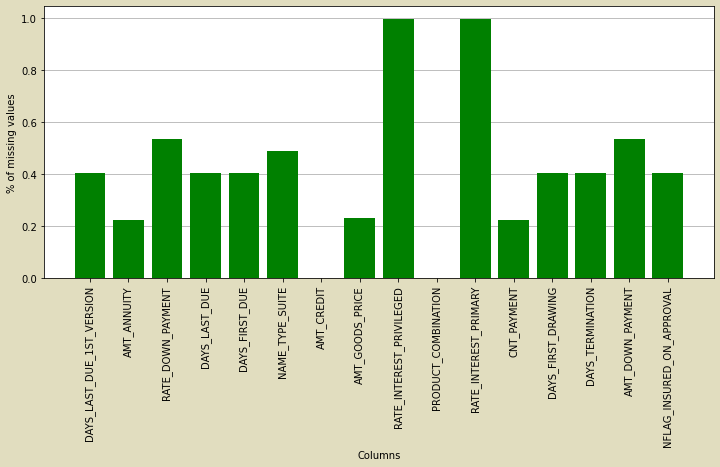

In [ ]:

describe_missing(prev_applicants , 'green' , (12,5))


In [ ]:

# Converting values if NaN = 0 , if not NaN = 1
prev_applicants['RATE_INTEREST_PRIMARY'][prev_applicants['RATE_INTEREST_PRIMARY'].notna()] = 1
prev_applicants['RATE_INTEREST_PRIVILEGED'][prev_applicants['RATE_INTEREST_PRIVILEGED'].notna()] = 1
prev_applicants['RATE_INTEREST_PRIMARY'].fillna(0 , inplace=True)
prev_applicants['RATE_INTEREST_PRIVILEGED'].fillna(0 , inplace=True)

# 365243 is 1 year used for unknown time in future (as used by Home Credit)
prev_applicants['DAYS_FIRST_DUE'].fillna(365243.0 , inplace=True)
prev_applicants['DAYS_FIRST_DRAWING'].fillna(365243.0 , inplace=True)
prev_applicants['DAYS_TERMINATION'].fillna(365243.0 , inplace=True)

# Redundant column
prev_applicants.drop(columns = 'NAME_TYPE_SUITE' , inplace=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Feature engineering

In [ ]:

# Converting categorical columns to numerical
categorical_cols = ['NAME_CONTRACT_TYPE' , 'WEEKDAY_APPR_PROCESS_START' , 'FLAG_LAST_APPL_PER_CONTRACT' , 'NAME_CASH_LOAN_PURPOSE' , 
                    'NAME_PAYMENT_TYPE' , 'CODE_REJECT_REASON' , 'NAME_CLIENT_TYPE' , 'NAME_GOODS_CATEGORY' , 'NAME_PORTFOLIO' ,
                    'NAME_PRODUCT_TYPE' , 'CHANNEL_TYPE' , 'NAME_SELLER_INDUSTRY' , 'PRODUCT_COMBINATION' , 'NAME_CONTRACT_STATUS' ,
                    'NAME_YIELD_GROUP']
categorical_to_numerical(prev_applicants , categorical_cols)

# Extra features
prev_applicants['INTEREST_RATE'] = prev_applicants['AMT_ANNUITY'] / prev_applicants['AMT_CREDIT']

# Grouping all SK_ID_PREV values for each SK_ID_CURR
prev_applicants.drop('SK_ID_PREV' , axis=1 , inplace=True)
final_prev_applicants = prev_applicants.groupby('SK_ID_CURR' , as_index=False).agg({'AMT_ANNUITY':'sum' , 
                                                                                    'AMT_APPLICATION':'sum' ,
                                                                                    'AMT_CREDIT':'sum' , 
                                                                                    'AMT_DOWN_PAYMENT':'sum' ,
                                                                                    'AMT_GOODS_PRICE':'sum' ,
                                                                                    'CNT_PAYMENT':'sum'})
te = prev_applicants.groupby('SK_ID_CURR' , as_index=False).agg('mean')
final_prev_applicants = final_prev_applicants.merge(te , how='left' , on='SK_ID_CURR' , suffixes=('_sum' , '_avg'))
del(te)

final_prev_applicants = final_prev_applicants.astype(np.float32)


## installments

### Missing values

No. of missing columns -  2 

{'AMT_PAYMENT', 'DAYS_ENTRY_PAYMENT'} 



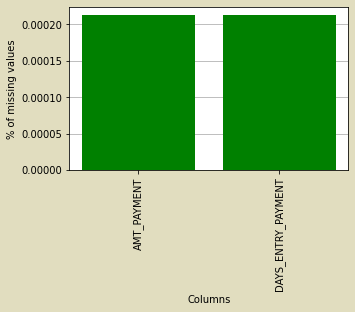

In [ ]:

describe_missing(installments , 'green' , (5,3))


In [ ]:

# Dropping rows with NaN values
installments.dropna(axis=0 , inplace=True)


### Feature engineering

In [ ]:

# New features
installments['LATE_DAYS'] = installments['DAYS_INSTALMENT'] - installments['DAYS_INSTALMENT']
installments['INSTALLMENT_DIFF'] = installments['AMT_INSTALMENT'] - installments['AMT_PAYMENT']

# Convert days to months to group by months
installments['DAYS_INSTALMENT'] //= 30
installments['DAYS_ENTRY_PAYMENT'] //= 30

# 1st Grouping level - ID , DAYS_INSTALLMENT(previously converted to months name not changed) 
installments_rnn = installments.groupby(['SK_ID_CURR' , 'DAYS_INSTALMENT'] , as_index=False).agg({'NUM_INSTALMENT_VERSION':'mean' ,
                                                                                                  'NUM_INSTALMENT_NUMBER':'sum' ,
                                                                                                  'AMT_INSTALMENT':'sum',
                                                                                                  'AMT_PAYMENT':'sum',
                                                                                                  'LATE_DAYS':'sum',
                                                                                                  'INSTALLMENT_DIFF':'sum'})

# 2nd Grouping level - months for an ID is aggregated
installments.sort_values('NUM_INSTALMENT_NUMBER' , ignore_index=True , inplace=True)
installments_final = installments.groupby(['SK_ID_PREV','SK_ID_CURR'] , as_index=False).agg({'NUM_INSTALMENT_VERSION':'mean' , 
                                                                                             'NUM_INSTALMENT_NUMBER':'max' , 
                                                                                             'DAYS_ENTRY_PAYMENT':'max', 
                                                                                             'AMT_INSTALMENT':'mean' , 
                                                                                             'AMT_PAYMENT':'mean' , 
                                                                                             'LATE_DAYS':'max' , 
                                                                                             'INSTALLMENT_DIFF':'max'})

installments_final.drop('SK_ID_PREV' , axis=1 , inplace=True)
installments_final = installments_final.groupby('SK_ID_CURR' , as_index=False).agg('mean')

te = installments_rnn.groupby('SK_ID_CURR' , as_index=False).agg({'AMT_INSTALMENT':'max' , 'AMT_PAYMENT':'std'})
installments_final = installments_final.merge(te , how='left' , on='SK_ID_CURR' , suffixes=('_avg' , '_extra'))
del(te)

installments_rnn = installments_rnn.astype(np.float32)
installments_final = installments_final.astype(np.float32)


## card_balances

### Missing values

No. of missing columns -  9 

{'AMT_PAYMENT_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'AMT_INST_MIN_REGULARITY', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_POS_CURRENT'} 



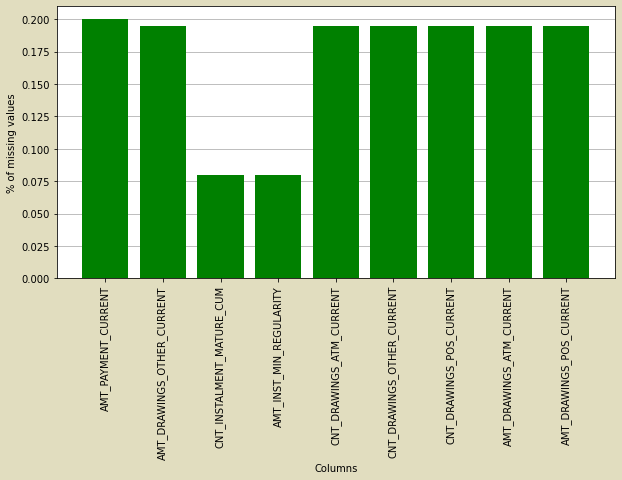

In [ ]:

describe_missing(card_balances , 'green' , (10,5))


In [ ]:

# Handling missing values
card_balances['AMT_INST_MIN_REGULARITY'].fillna(0 , inplace=True) 
card_balances['CNT_DRAWINGS_ATM_CURRENT'].fillna(0 , inplace=True)
card_balances['AMT_DRAWINGS_OTHER_CURRENT'].fillna(0 , inplace=True)
card_balances['AMT_PAYMENT_CURRENT'].fillna(0 , inplace=True)
card_balances['AMT_DRAWINGS_ATM_CURRENT'].fillna(0 , inplace=True)
card_balances['CNT_DRAWINGS_POS_CURRENT'].fillna(0 , inplace=True)
card_balances['AMT_DRAWINGS_POS_CURRENT'].fillna(0 , inplace=True)
card_balances['CNT_DRAWINGS_OTHER_CURRENT'].fillna(0 , inplace=True)
card_balances.dropna(axis = 0  , inplace=True)


###Feature engineering

In [ ]:

print(card_balances['NAME_CONTRACT_STATUS'].unique())

# Converting categorical columns to numerical
card_contract_status_tokens = {'Completed':1 , 'Active':3 , 'Approved':3 ,
                               'Sent proposal':0 , 'Signed':0 ,'Demand':2 , 'Refused':2}
                              
card_balances['NAME_CONTRACT_STATUS'] = card_balances['NAME_CONTRACT_STATUS'].apply(lambda x:card_contract_status_tokens.get(x , 0))
card_balances.drop('SK_ID_PREV' , axis = 1 , inplace=True)

# Monthly data for each ID is aggregated
rnn_card_balances = card_balances.groupby(['SK_ID_CURR' , 'MONTHS_BALANCE'] , as_index=False).agg('sum')
final_card_balances = rnn_card_balances.groupby('SK_ID_CURR' , as_index=False).agg('mean')
final_card_balances = final_card_balances.merge(rnn_card_balances.groupby('SK_ID_CURR' , as_index=False).std() , on='SK_ID_CURR' , suffixes=('_avg','_std'))

rnn_card_balances = rnn_card_balances.astype(np.float32)
final_card_balances = final_card_balances.astype(np.float32)


['Active' 'Completed' 'Demand' 'Signed']


## pos_balances

### Missing values

No. of missing columns -  2 

{'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE'} 



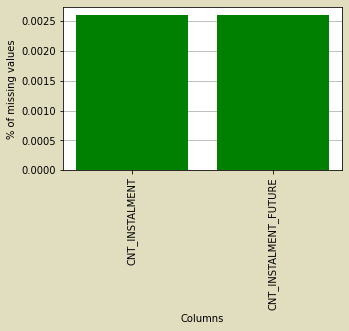

In [ ]:

describe_missing(POS_balances , 'green' , (5,3))


In [ ]:

# Dropping NaN rows
POS_balances.dropna(axis=0 , inplace=True)


### Feature engineering

In [ ]:

print(POS_balances['NAME_CONTRACT_STATUS'].unique())

# Converting categorical columns to numerical
POS_contract_status_tokens = {'Completed':1 , 'Active':3 , 'Approved':3 , 'XNA':0 ,
                              'Returned to the store':2 , 'Signed':0 ,'Demand':2 , 'Canceled':2 , 'Amortized debt':4}
                             
POS_balances['NAME_CONTRACT_STATUS'] = POS_balances['NAME_CONTRACT_STATUS'].apply(lambda x:POS_contract_status_tokens.get(x))
POS_balances.drop('SK_ID_PREV' , axis=1 , inplace=True)

# Aggregate monthly data for each ID
rnn_POS_balances = POS_balances.groupby(['SK_ID_CURR' , 'MONTHS_BALANCE'] , as_index=False).agg({'CNT_INSTALMENT':'max',
                                                                                                 'CNT_INSTALMENT_FUTURE':'min',
                                                                                                 'NAME_CONTRACT_STATUS':'mean',
                                                                                                 'SK_DPD':'sum',
                                                                                                 'SK_DPD_DEF':'sum'})

POS_balances_final = rnn_POS_balances.groupby('SK_ID_CURR' , as_index=False).agg('sum')

# New feature
POS_balances_final['PENDING_INST_RATIO'] = POS_balances_final['CNT_INSTALMENT_FUTURE'] / POS_balances_final['CNT_INSTALMENT'] 

rnn_POS_balances = rnn_POS_balances.astype(np.float32)
POS_balances_final = POS_balances_final.astype(np.float32)


['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'Amortized debt']


# Visualization

In [ ]:

def visualize_univariate( numerical_data , columns , hue , fig_size):

    data = numerical_data.loc[ : , columns ]
    data[hue] = numerical_data[hue]

    fig , axes = plt.subplots( int(np.ceil(len(columns)/4)) , 4 , figsize = fig_size , facecolor="#e1ddbf")
    axes = axes.flatten()

    for i,j in enumerate(columns):

        sns.kdeplot(data=data , x=j , hue=hue , ax=axes[i] , common_norm=False , palette='rocket')
        axes[i].grid()

        # data[j+'_percentiles'] = pd.qcut( numerical_data[j] , 4 , duplicates='drop' )
        # sns.countplot(x=j+'_percentiles' , data=data , hue=hue , ax=axes[i])
   
    plt.show()

def visualize_bivariate( numerical_data , primary_column , primary_type_numerical , reference_columns_list , hue , scale , fig_size ):
    
    data = numerical_data.loc[ : , reference_columns_list ]
    data[hue] = numerical_data[hue]

    data[primary_column] = numerical_data[primary_column]

    if primary_type_numerical:
        q_column = primary_column+'_percentiles'
        data[q_column] = pd.qcut(numerical_data[primary_column] , 4 , duplicates='drop')

        fig , axes = plt.subplots( int(np.ceil(len(reference_columns_list)/4)) , 4 , figsize = fig_size , facecolor="#e1ddbf")
        axes = axes.flatten()

        for i,j in enumerate(reference_columns_list):

            sns.violinplot(x=q_column , y=j , data=data , hue=hue , 
                          split =True , scale=scale , 
                          ax=axes[i] ,
                          palette=['yellow','red'])
                  
        plt.show()

    else:

        fig , axes = plt.subplots( int(np.ceil(len(reference_columns_list)/4)) , 4 , figsize = fig_size , facecolor="#e1ddbf")
        axes = axes.flatten()

        for i,j in enumerate(reference_columns_list):

            sns.violinplot(x=primary_column , y=j , data=data , hue=hue , 
                          split =True , scale=scale , 
                          ax=axes[i] ,
                          palette=['yellow','red'])
            
        plt.show()


In [ ]:

merged_train = train_main\
               .merge(final_bureau , how='left' , on='SK_ID_CURR' , suffixes=('l1','r1') )\
               .merge(final_prev_applicants , how='left' , on='SK_ID_CURR' , suffixes=('l2','r2') )\
               .merge(installments_final , how='left' , on='SK_ID_CURR' , suffixes=('l3','r3') )\
               .merge(final_card_balances , how='left' , on='SK_ID_CURR' , suffixes=('l4','r4') )\
               .merge(POS_balances_final , how='left' , on='SK_ID_CURR' , suffixes=('l5','r5') )\

merged_test = test_main\
              .merge(final_bureau , how='left' , on='SK_ID_CURR' , suffixes=('l1','r1') )\
              .merge(final_prev_applicants , how='left' , on='SK_ID_CURR' , suffixes=('l2','r2') )\
              .merge(installments_final , how='left' , on='SK_ID_CURR' , suffixes=('l3','r3') )\
              .merge(final_card_balances , how='left' , on='SK_ID_CURR' , suffixes=('l4','r4') )\
              .merge(POS_balances_final , how='left' , on='SK_ID_CURR' , suffixes=('l5','r5') )\

print(merged_train.shape)
print(merged_test.shape)


(307511, 267)
(48744, 266)


## Data Imbalance

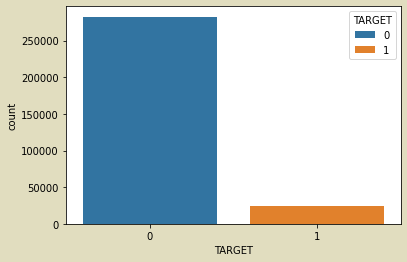

In [ ]:

# Sample distribution of True and False values
plt.figure(facecolor="#e1ddbf")
sns.countplot(x='TARGET' , hue='TARGET' , data=train_main  , dodge=False) 
plt.show()


## Feature Importance

In [ ]:

X = merged_train.drop(columns=['SK_ID_CURR','TARGET'])
y = merged_train['TARGET']

importance_cls = xgb.XGBClassifier(n_estimators=2 , use_label_encoder=False )
importance_validate = GridSearchCV(estimator=importance_cls , param_grid={'max_depth':[6,8,10,12,14]} , scoring='roc_auc' , cv=3, verbose=0)
importance_validate.fit( X , y )
print(importance_validate.best_params_)


{'max_depth': 10}


In [ ]:

importance_cls = xgb.XGBClassifier( n_estimators=2 , use_label_encoder=False , max_depth=10 )
importance_cls.fit( X , y )
important_features = X.columns[importance_cls.feature_importances_.argsort()]
feature_scores = np.sort(importance_cls.feature_importances_)


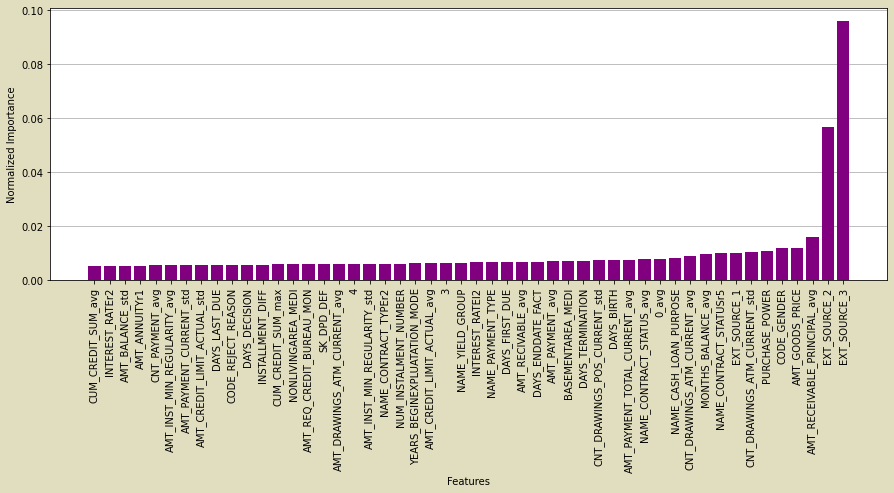

In [ ]:

plt.figure(figsize=(15,5), facecolor="#e1ddbf")
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.bar(important_features[-50:] , feature_scores[-50:] , color = 'purple' , zorder=2.5)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.show()


## Univariate Analysis

In below visualizations, we attempt to bin numerical data into percentiles (at most 4 quartiles) and count based on 'TARGET' in each perentile bin. If a column is not seperable into bins, the graph will return a single bar and also means that the column doesn't have enough variance.

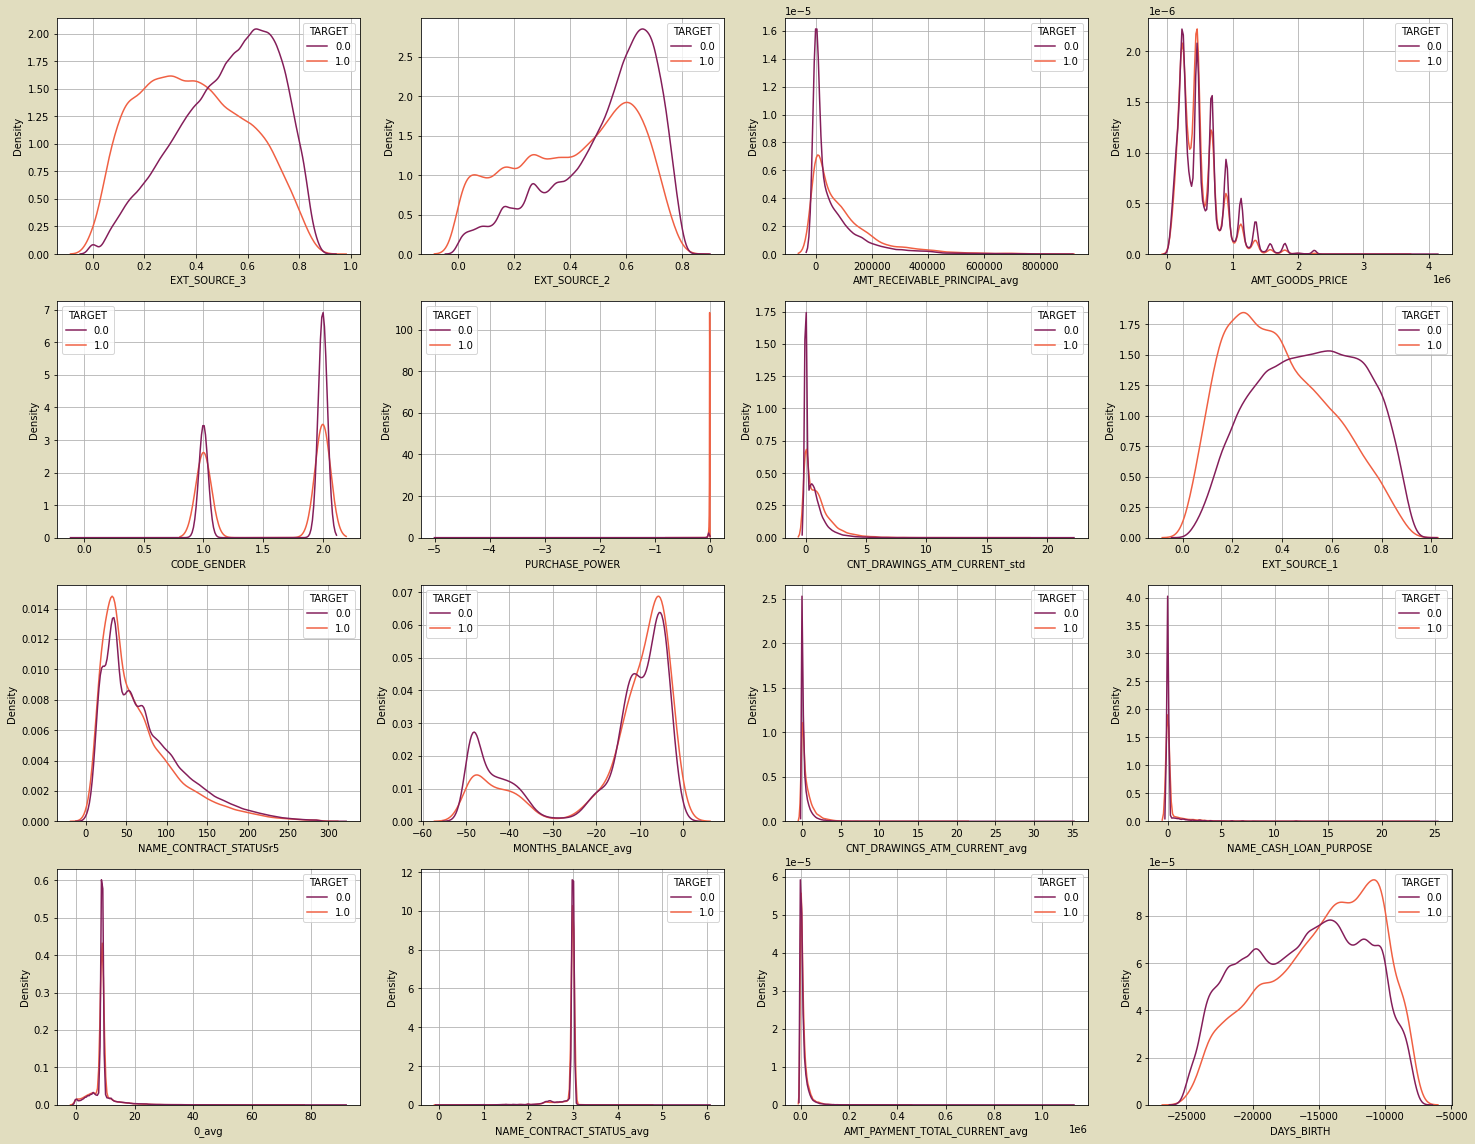

In [ ]:

visualize_univariate( merged_train , ['EXT_SOURCE_3' , 'EXT_SOURCE_2' , 'AMT_RECEIVABLE_PRINCIPAL_avg' , 'AMT_GOODS_PRICE' , 'CODE_GENDER' ,
                                      'PURCHASE_POWER' , 'CNT_DRAWINGS_ATM_CURRENT_std' , 'EXT_SOURCE_1' , 'NAME_CONTRACT_STATUSr5' , 
                                      'MONTHS_BALANCE_avg' , 'CNT_DRAWINGS_ATM_CURRENT_avg' , 'NAME_CASH_LOAN_PURPOSE' , '0_avg' , 
                                      'NAME_CONTRACT_STATUS_avg' , 'AMT_PAYMENT_TOTAL_CURRENT_avg' , 'DAYS_BIRTH'] , 'TARGET' , (25,20) )


**Observations**

at higher percentiles default increases for below features

*   AMT_RECEIVABLE_PRINCIPAL_avg - avg amt receivable from previous credits
*   CNT_DRAWINGS_ATM_CURRENT_std - no of atm drawings this month (std of multiple cards)
*   CNT_DRAWINGS_ATM_CURRENT_avg - no of atm drawings this month (avg of multiple cards)
*   MONTHS_BALANCE_avg - average tenurity of previous credits 
*   DAYS_BIRTH - age in negative days from day of application

at higher percentiles default decreases for below features

*   EXT_SOURCE_3 - credit rating
*   EXT_SOURCE_2 - credit rating
*   EXT_SOURCE_1 - credit rating
*   NAME_CONTRACT_STATUSr5 - status could be approved , cancelled , etc
*   AMT_GOODS_PRICE
*   CODE_GENDER - 1 is M and 2 is F

below features appear to be non seperable

*   NAME_CASH_LOAN_PURPOSE - 
*   0_avg - average count of no due in a month in previous loans 
*   NAME_CONTRACT_STATUS_avg
*   AMT_PAYMENT_TOTAL_CURRENT_avg - current payment on previous credits

## Bivariate Analysis

In below visualizations distribution, bins are created for the primary column and distribution for reference columns are plotted as violin plots. The red colored side of distribution is for TARGET = 1 and yellow is for TARGET = 0. These distributions show interdependence of features to classify TARGET. 


An example of finding seperability shown below for 'DAYS_FIRST_DRAWING' (y-axis) vs 'AMT_RECEIVABLE_PRINCIPAL_avg_percentiles' (x-axis)



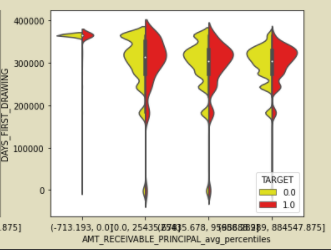

We don't want to care about the messed up calibration on x-axis, because it is just the range of quartiles. Important things to notice is that in the 2nd and 3rd quartiles, at higher values of y-axis probability of TARGET=1 is less than TARGET=0. In graphs where there are not 4 quartiles, it's only because 2 or more quartiles falling in same range (values are inserperable into quartiles in that range). 

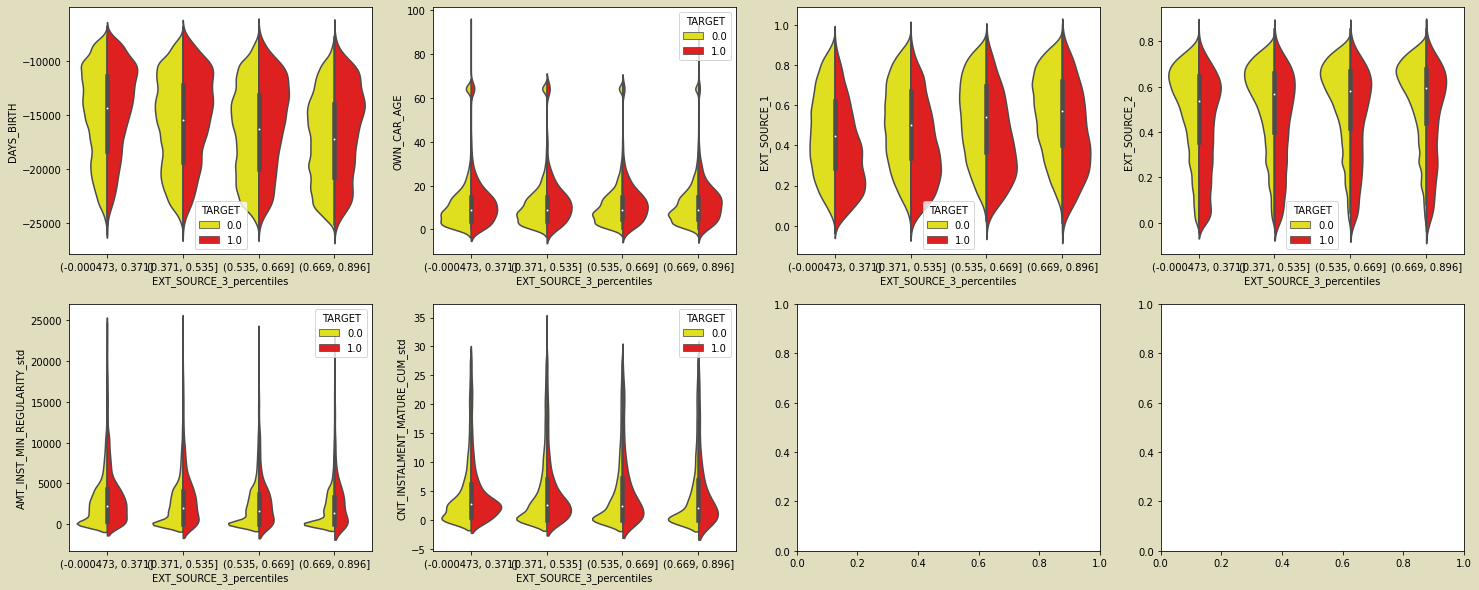

In [ ]:
visualize_bivariate(numerical_data = merged_train , 
                    primary_column = 'EXT_SOURCE_3' ,
                    primary_type_numerical =  True ,
                    reference_columns_list = ['DAYS_BIRTH' , 'OWN_CAR_AGE' , 'EXT_SOURCE_1' , 'EXT_SOURCE_2' , 'AMT_INST_MIN_REGULARITY_std' ,
                                              'CNT_INSTALMENT_MATURE_CUM_std'], 
                    hue='TARGET' ,
                    scale = 'area' ,
                    fig_size = (25,10))

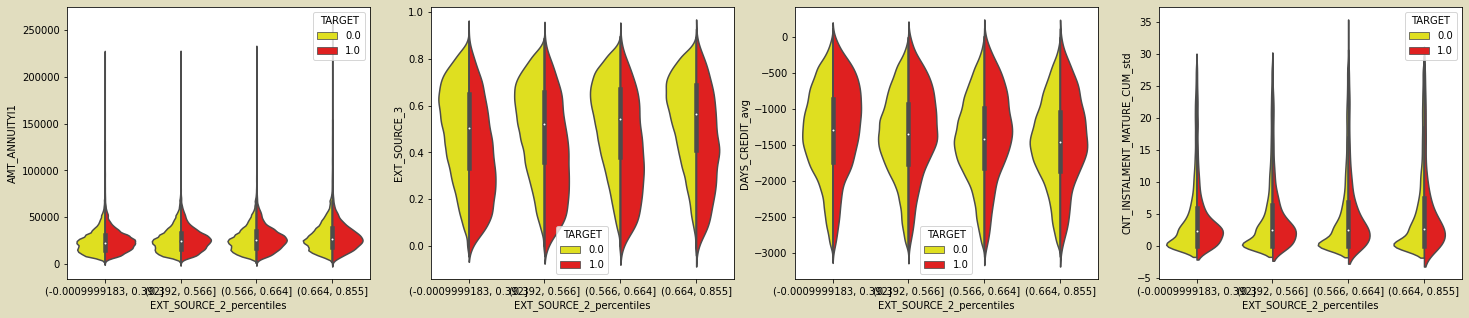

In [ ]:

visualize_bivariate(numerical_data = merged_train , 
                    primary_column = 'EXT_SOURCE_2' ,
                    primary_type_numerical =  True ,
                    reference_columns_list = ['AMT_ANNUITYl1' , 'EXT_SOURCE_3' , 'DAYS_CREDIT_avg' , 'CNT_INSTALMENT_MATURE_CUM_std'] ,                                              
                    hue='TARGET' ,
                    scale = 'area' ,
                    fig_size = (25,5))


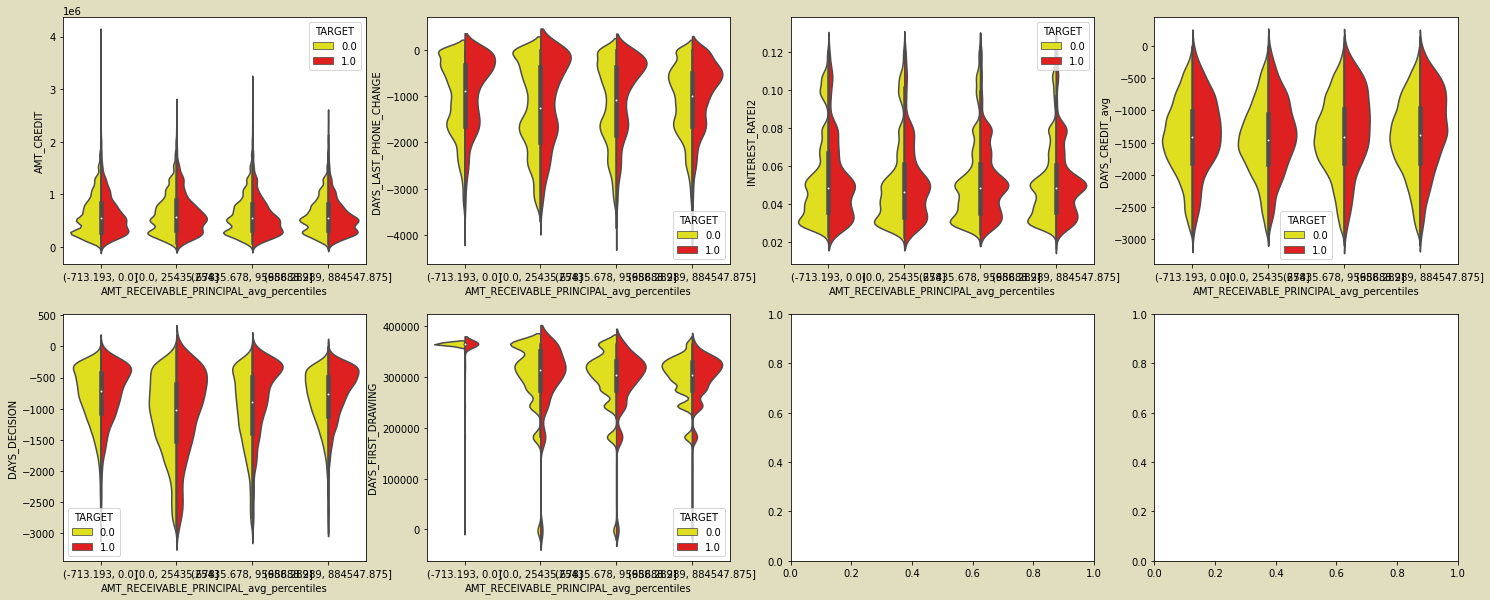

In [ ]:

visualize_bivariate(numerical_data = merged_train , 
                    primary_column = 'AMT_RECEIVABLE_PRINCIPAL_avg' ,
                    primary_type_numerical =  True ,
                    reference_columns_list = ['AMT_CREDIT' , 'DAYS_LAST_PHONE_CHANGE' , 'INTEREST_RATEl2' , 'DAYS_CREDIT_avg' , 
                                              'DAYS_DECISION' , 'DAYS_FIRST_DRAWING'], 
                    hue='TARGET' ,
                    scale = 'area' ,
                    fig_size = (25,10))


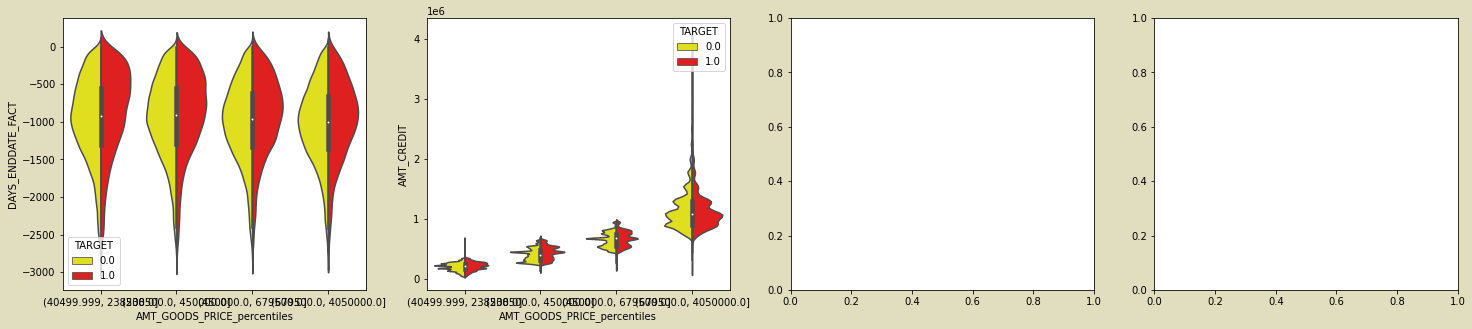

In [ ]:

visualize_bivariate(numerical_data = merged_train , 
                    primary_column = 'AMT_GOODS_PRICE' ,
                    primary_type_numerical =  True ,
                    reference_columns_list = ['DAYS_ENDDATE_FACT' , 'AMT_CREDIT'], 
                    hue='TARGET' ,
                    scale = 'area' ,
                    fig_size = (25,5))


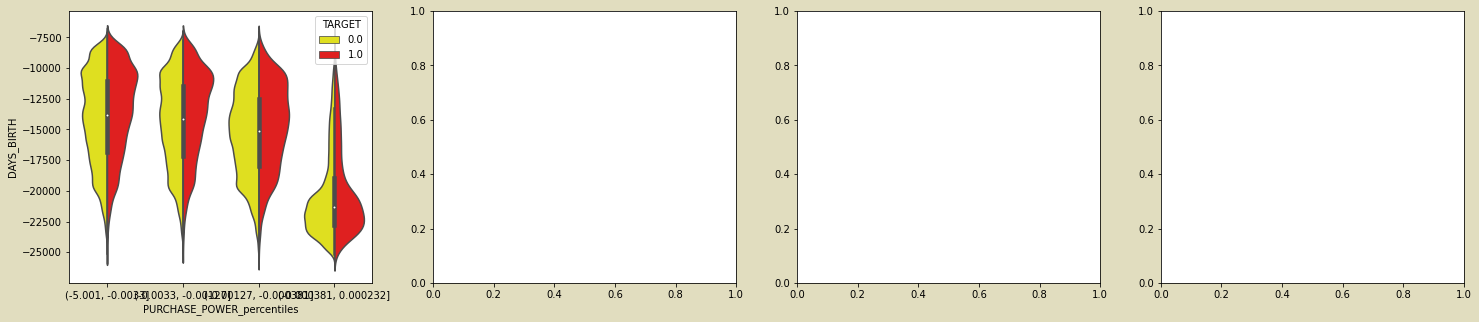

In [ ]:

visualize_bivariate(numerical_data = merged_train , 
                    primary_column = 'PURCHASE_POWER' ,
                    primary_type_numerical =  True ,
                    reference_columns_list = ['DAYS_BIRTH'] , 
                    hue='TARGET' ,
                    scale = 'area' ,
                    fig_size = (25,5))


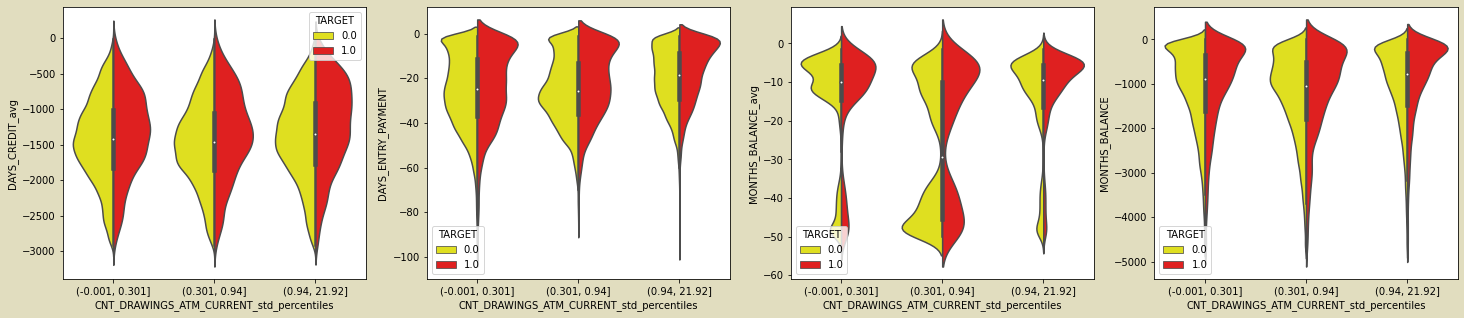

In [ ]:

visualize_bivariate(numerical_data = merged_train , 
                    primary_column = 'CNT_DRAWINGS_ATM_CURRENT_std' ,
                    primary_type_numerical =  True ,
                    reference_columns_list = ['DAYS_CREDIT_avg' , 'DAYS_ENTRY_PAYMENT' , 'MONTHS_BALANCE_avg' , 'MONTHS_BALANCE'] , 
                    hue='TARGET' ,
                    scale = 'area' ,
                    fig_size = (25,5))


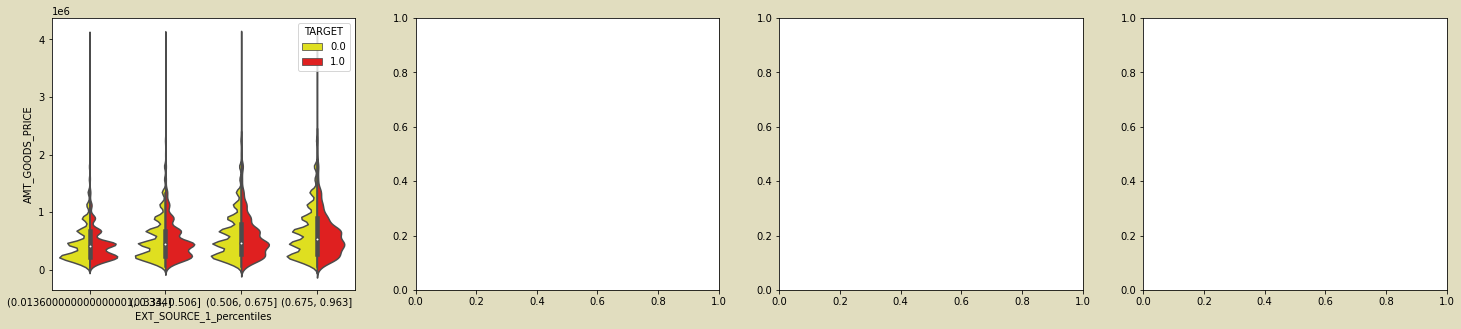

In [ ]:

visualize_bivariate(numerical_data = merged_train , 
                    primary_column = 'EXT_SOURCE_1' ,
                    primary_type_numerical =  True ,
                    reference_columns_list = ['AMT_GOODS_PRICE'] , 
                    hue='TARGET' ,
                    scale = 'area' ,
                    fig_size = (25,5))


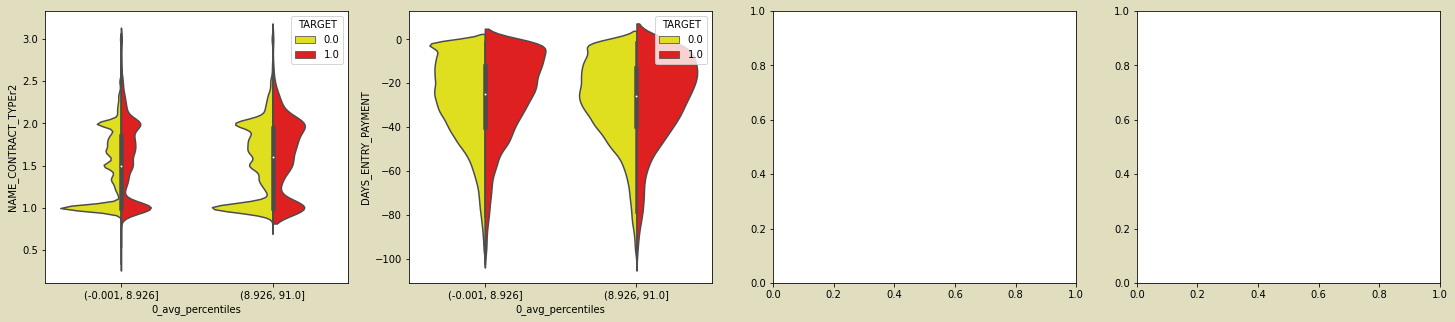

In [ ]:

visualize_bivariate(numerical_data = merged_train , 
                    primary_column = '0_avg' ,
                    primary_type_numerical =  True ,
                    reference_columns_list = ['NAME_CONTRACT_TYPEr2' , 'DAYS_ENTRY_PAYMENT'] , 
                    hue='TARGET' ,
                    scale = 'area' ,
                    fig_size = (25,5))


## Multivariate Analysis

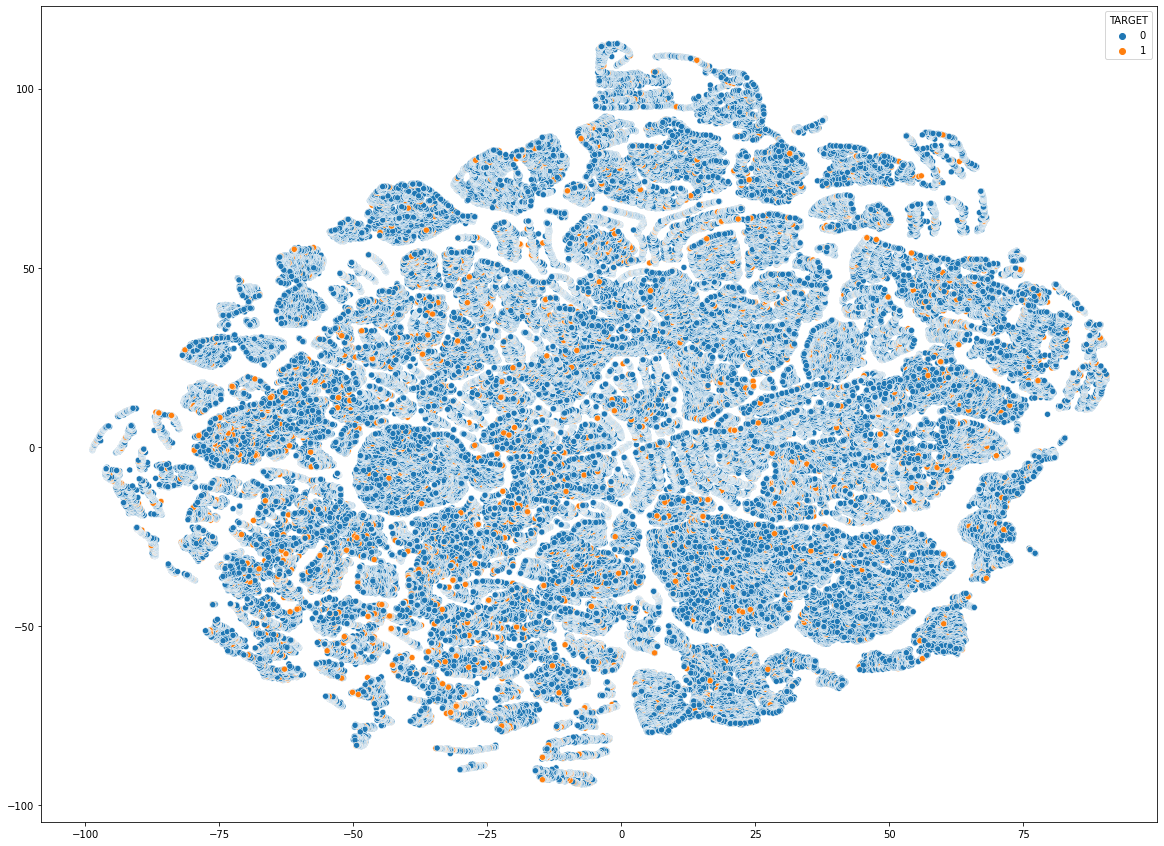

In [ ]:

train_main_tsne = merged_train.fillna(0)
visual = TSNE(n_components=2 , perplexity=30.0)
plot = visual.fit_transform(train_main_tsne.drop(columns='TARGET'))

plt.figure(figsize=(20,15))
sns.scatterplot(x=plot[:,0] , y=plot[:,1] , hue=train_main['TARGET'])
plt.show()


Above TSNE plot shows that the classical machine learning models will not efficiently classify TARGET class, as TARGET = 0 seems to be concentrated in some regions but well mixed with other class.

# Models

## Random Forest Model

3-fold crossvalidation tuning was done for all hyper-parameters assigned in classifier class. Random forest (bagging type) uses stack of high bias models - high 'num_leaves' parameter for small 'subsample' (rows) ensure the high bias. Subsampling rows is a necessity for random forest to work on the over-fit with no. of estimators. The train and test loss converged at 'n_estimators' = 300

NOTE: Subsampling should not be as low as we chose in random forest, as it will risk high variance, but since it worked out with no. of estimators in tuning I went forward with it.

In [ ]:

classifier = LGBMClassifier(objective='binary' , boosting_type='rf' , subsample_freq=1 , 
                            num_leaves = 150 , subsample=0.25 , n_estimators=300)
 
X = merged_train.drop(columns=['TARGET','SK_ID_CURR'])
y = merged_train['TARGET'].astype(np.int32)

X_test , X_train , y_test , y_train = train_test_split(X , y , test_size = 0.8 , stratify=merged_train['TARGET'])
 
classifier.fit( X_train , y_train )
print('train score : ' ,roc_auc_score(y_train , classifier.predict_proba(X_train)[:,1]))
print('test score : ' ,roc_auc_score(y_test , classifier.predict_proba(X_test)[:,1]))


train score :  0.7582163715936694
test score :  0.7351605604870758


## Gradient boosted trees

3-fold crossvalidation tuning was done for all hyper-parameters assigned in classifier class. Histogram based binning option of LightGBM was switched off by assigning 'subsample_for_bin' parameter, since the size of our dateset will not need faster alternatives. Here we have not opted to subsample rows and reduced the 'num_leaves' to 50. We are using 'gbdt' option to classify , which requires high variance base learners ('num_leaves' reduced), thus we need all the rows to find error corrcections to loss function in 'closed form' gradient descent. 

In [ ]:

classifier = LGBMClassifier(objective='binary' , silent='False' , importance_type='gain' , reg_lambda=1 , 
                            subsample_for_bin=300000  , learning_rate=0.01 , num_leaves=50 , n_estimators=100) 

X = merged_train.drop(columns=['TARGET','SK_ID_CURR'])
y = merged_train['TARGET'].astype(np.int32)

X_test , X_train , y_test , y_train = train_test_split(X , y , test_size = 0.8 , stratify=merged_train['TARGET'])
 
classifier.fit( X_train , y_train )
print('train score : ' ,roc_auc_score(y_train , classifier.predict_proba(X_train)[:,1]))
print('test score : ' ,roc_auc_score(y_test , classifier.predict_proba(X_test)[:,1]))


train score :  0.7611435012609681
test score :  0.7397934879993122
